In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pandas as pd
from astropy.io import fits
from scipy.signal import gaussian
from scipy.stats import norm

from IPython.display import display
from ipywidgets import interactive, FloatSlider, fixed
import ipywidgets as widgets
%matplotlib inline

In [2]:
import pcmdpy as ppy

GPU acceleration enabled


In [3]:
if ppy.gpu_utils._GPU_AVAIL:
    ppy.gpu_utils.initialize_gpu(n=0)

using given n: 0
Starting SourceModule Code
Getting function
Past the SourceModule code
CUDAC Available


In [4]:
f = [ppy.instrument.ACS_WFC_F814W(1.0), ppy.instrument.ACS_WFC_F475W(1.0)]
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, gpu=True)

In [5]:
true_psfs = [f[0]._psf, f[1]._psf]
true_psfs[0] /= np.sum(true_psfs[0])
true_psfs[1] /= np.sum(true_psfs[1])

In [6]:
sig = 0.2
delta = 0.
psf0 = np.outer(gaussian(73, sig), gaussian(73, sig)) + delta
psf0 /= psf0.sum()

sig = 0.4
delta = 0.
psf1 = np.outer(gaussian(73, sig), gaussian(73, sig)) + delta
psf1 /= psf1.sum()

sig = 0.6
psf2 = np.outer(gaussian(73, sig), gaussian(73, sig)) + delta
psf2 /= psf2.sum()

sig = 1.0
psf3 = np.outer(gaussian(73, sig), gaussian(73, sig)) + delta
psf3 /= psf3.sum()

sig = 2.0
psf4 = np.outer(gaussian(73, sig), gaussian(73, sig)) + delta
psf4 /= psf4.sum()

In [19]:
def make_psf_pcmd(ims, sig=None):
    filters = driv.iso_model.filters
    if (sig is None):
        filters[0]._psf = true_psfs[0]
        filters[1]._psf = true_psfs[1]
    elif (sig <= 0.02):
        mags = np.array([f.counts_to_mag(im.flatten()) for f,im in zip(filters, ims)])
        pcmd = ppy.utils.make_pcmd(mags)
        return pcmd
    else:
        psf = np.outer(gaussian(75, sig), gaussian(75, sig))# + 1e-4
        psf /= psf.sum()
        filters[0]._psf = filters[1]._psf = psf
    images = np.array([f.psf_convolve(im) for f,im in zip(filters, ims)])
    mags = np.array([f.counts_to_mag(im.flatten()) for f,im in zip(filters, images)])
    pcmd = ppy.utils.make_pcmd(mags)
    return pcmd

In [26]:
def plot_psf_pcmd(ims, sig, y_lim=[10., 0]):
    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,6))
    n = mpl.colors.LogNorm()
    b=[np.linspace(1.0, 4.0, 100), np.linspace(y_lim[1], y_lim[0], 100)]

    plt.subplot(axes[0])
    pcmd_true = make_psf_pcmd(ims, sig=None)
    _ = plt.hist2d(pcmd_true[1], pcmd_true[0], norm=n, bins=b)
    axes[0].set_title('True PSF')

    plt.subplot(axes[1])
    pcmd_1 = make_psf_pcmd(ims, sig=sig)
    _ = plt.hist2d(pcmd_1[1], pcmd_1[0], norm=n, bins=b)
    axes[1].set_title('Gaussian PSF: {0:.2f} pix'.format(sig))
    for ax in axes:
        iso_model.plot_isochrone(g, axes=ax)
    axes[0].set_ylim([y_lim[0], y_lim[1]])
    axes[0].set_xlim([b[0][0], b[0][-1]])
    plt.subplots_adjust(wspace=0.06)
    plt.colorbar()
    plt.show()

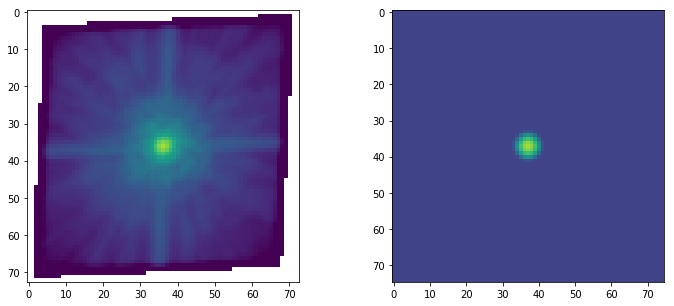

In [27]:
sig = 0.95
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
n = mpl.colors.LogNorm(vmin=1e-6, vmax=1)
axes[0].imshow(true_psfs[1], norm=n)
psf = np.outer(gaussian(75, sig), gaussian(75, sig)) + 1e-4
psf /= np.sum(psf)
axes[1].imshow(psf, norm=n)

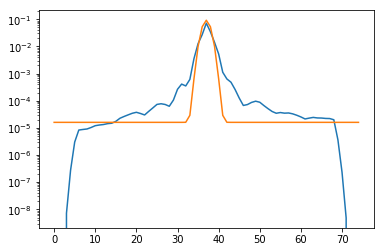

In [28]:
plt.plot(true_psfs[0][:,36])
plt.plot(psf[:,36])
plt.yscale('log')

In [29]:
%%time
g = ppy.galaxy.DefaultSSP.get_model(np.array([0., -2., 1., 10.0]))

N_im = 256

mags, ims_0 = driv.simulate(g, N_im, psf=False)

CPU times: user 73 ms, sys: 29 ms, total: 102 ms
Wall time: 201 ms


In [30]:
# sig_widget = widgets.Play(value=0.2, min=0.2, max=2.0, step=0.1, interval=10, disabled=False)
sig_widget = FloatSlider(min=0.0, max=2.0, step=0.05, continuous_update=False, description='PSF (pix)')
interactive_plot = interactive(plot_psf_pcmd, ims=fixed(ims_0), y_lim=fixed([7, -5]), sig=sig_widget)
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
display(interactive_plot)
# sig_widget

In [32]:
%%time
g = ppy.galaxy.DefaultSSP.get_model(np.array([0., -2., 2., 10.0]))

N_im = 512

mags, ims_2 = driv.simulate(g, N_im, psf=False)

CPU times: user 164 ms, sys: 42 ms, total: 206 ms
Wall time: 293 ms


In [33]:
# sig_widget = widgets.Play(value=0.2, min=0.2, max=2.0, step=0.1, interval=10, disabled=False)
sig_widget = FloatSlider(min=0.0, max=2.0, step=0.05, continuous_update=False, description='PSF (pix)')
interactive_plot = interactive(plot_psf_pcmd, ims=fixed(ims_2), y_lim=fixed([2.5, -2.]), sig=sig_widget)
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
display(interactive_plot)

In [34]:
def bin_image(im, factor):
    im1 = im.reshape(im.shape[0]//factor, factor, im.shape[1]//factor, factor)
    im2 = im1.sum(axis=-1).sum(axis=-2)
    return im2

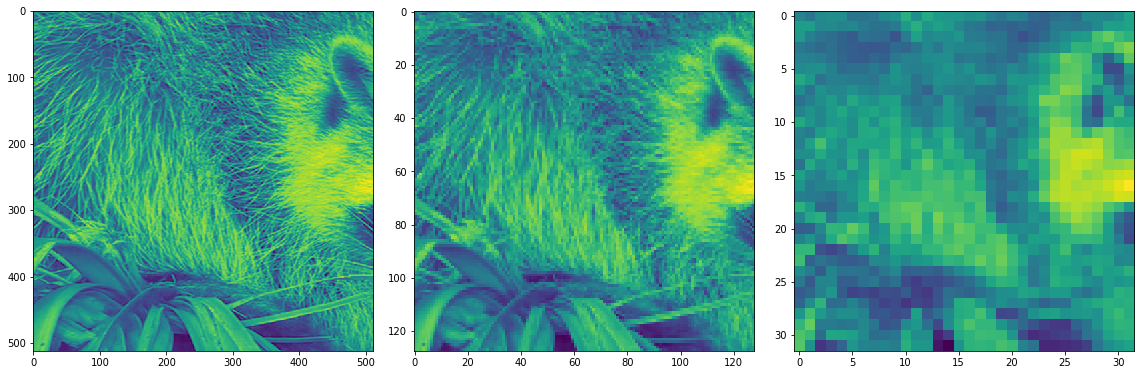

In [35]:
from scipy import misc
face = misc.face()[:512, :512, 0]
fig, axes = plt.subplots(ncols=3, figsize=(16, 6))
axes[0].imshow(bin_image(face, 1))
axes[1].imshow(bin_image(face, 4))
axes[2].imshow(bin_image(face, 16))
plt.tight_layout()

In [36]:
def subpixel_shift(image, dx, dy):
    assert(np.abs(dx)<= 1.)
    assert(np.abs(dy)<= 1.)
    image = np.copy(image)
#     if np.isclose(dx, 0.) and np.isclose(dy, 0.):
#         return image
    #roll the image by -1, 0, +1 in x and y
    rolls = np.zeros((3, 3, image.shape[0], image.shape[1]))
    for i, x in enumerate([-1, 0, 1]):
        for j, y in enumerate([-1, 0, 1]):
            rolls[j,i] = np.roll(np.roll(image, x, axis=1), y, axis=0)
    #make the coefficients for each corresponding rolled image
    coeffs = np.ones((3, 3))
    if np.isclose(dx, 0.):
        coeffs[:, 0] = coeffs[:, 2] = 0.
    elif dx < 0.:
        coeffs[:, 2] = 0.
        coeffs[:, 0] *= -dx
        coeffs[:, 1] *= 1 + dx
    else: 
        coeffs[:, 0] = 0.
        coeffs[:, 2] = dx
        coeffs[:, 1] *= 1 - dx
    if np.isclose(dy, 0.):
        coeffs[0, :] = coeffs[2, :] = 0.
    elif dy < 0.:
        coeffs[2, :] = 0.
        coeffs[0, :] *= -dy
        coeffs[1, :] *= 1 + dy
    else:
        coeffs[0, :] = 0.
        coeffs[2, :] *= dy
        coeffs[1, :] *= 1 - dy
    assert(np.isclose(np.sum(coeffs), 1.))
    result = np.zeros((image.shape[0], image.shape[0]))
    for i in range(3):
        for j in range(3):
            result += coeffs[i,j] * rolls[i,j]
    return result

def make_tile(image, shifts=[-.5, -.25, .25, .5], norm=False):
    tiles = np.zeros((len(shifts), len(shifts), image.shape[0], image.shape[1]))
    for i, dx in enumerate(shifts):
        for j, dy in enumerate(shifts):
            tiles[j,i] = subpixel_shift(image, dx, dy) 
            if norm:
                tiles[j,i] /= np.sum(tiles[j,i])
    return tiles

In [37]:
N_im_base = 256
sig = 1.0
pcmds = {}

In [43]:
%%time
# regular
for factor in [1,2,4]:
    print(factor)
    N_im = 1024*factor
    g = ppy.galaxy.DefaultTau.get_model(np.array([0., -2., 2. - 2*np.log10(factor), 10.0]))
    mags, ims = driv.simulate(g, N_im, psf=False)

    psf = np.outer(gaussian(73*factor, sig*factor), gaussian(73*factor, sig*factor))
    psf /= psf.sum()
    filters = driv.iso_model.filters
    filters[0]._psf = filters[1]._psf = psf
    images = np.array([f.psf_convolve(im) for f,im in zip(filters, ims)])
    # bin by factor
    images = np.array([bin_image(im, factor) for im in images])
#     images = images[:, :256, :256]
    mags = np.array([f.counts_to_mag(im.flatten()) for f,im in zip(filters, images)])
    pcmds[factor] = ppy.utils.make_pcmd(mags)

1
2
4
CPU times: user 54.5 s, sys: 20.4 s, total: 1min 14s
Wall time: 1min 15s


In [48]:
# with tiled true psf
print('Charlie\'s version')
N_im = 1024
psf_default = np.outer(gaussian(73, sig), gaussian(73, sig))
psf_default /= psf_default.sum()
g = ppy.galaxy.DefaultTau.get_model(np.array([0., -2., 2., 10.0]))
driv.filters = ppy.instrument.m31_filters()
# driv.filters
# filters[0]._psf = make_tile(psf_default, norm=True, shifts=[0., 0.25, 0.5, 0.75])
# filters[1]._psf = make_tile(psf_default, norm=True, shifts=[0., 0.25, 0.5, 0.75])
pcmds['tiled_charlie'], ims = driv.simulate(g, N_im, psf=True)

# # with tiled true psf
# print('My version')
# N_im = 1024
# g = ppy.galaxy.SSPModel(np.array([0., -2., 2., 10.0]))
# filters = driv.iso_model.filters
# filters[0]._psf = make_tile(psf_default, norm=True)
# filters[1]._psf = make_tile(psf_default, norm=True)
# pcmds['tiled_me'], ims = driv.simulate(g, N_im, psf=True)

Charlie's version


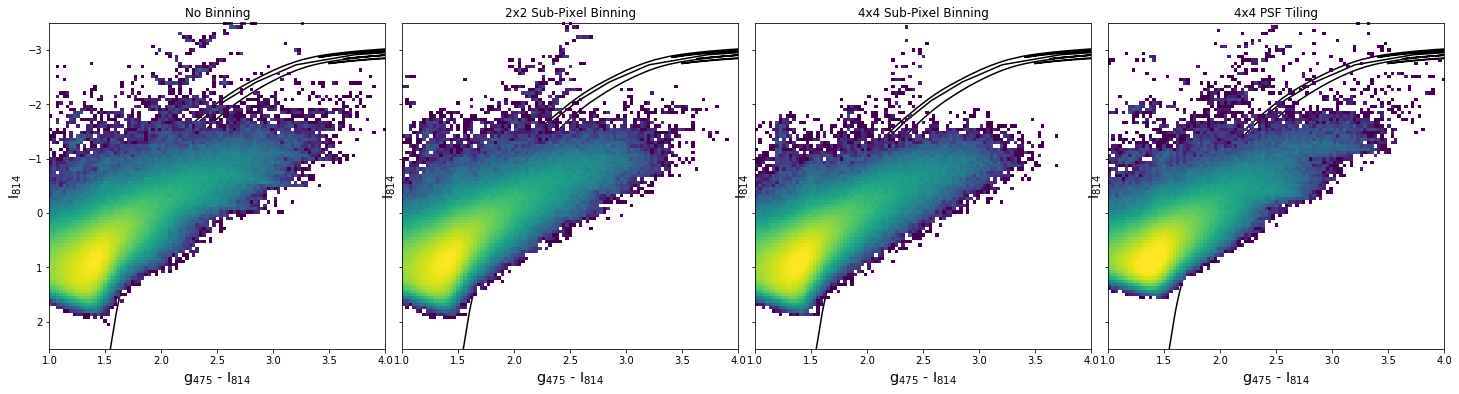

In [49]:
fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(25, 6))
n = mpl.colors.LogNorm()
b=[np.linspace(1.0, 4.0, 100), np.linspace(-3.5, 2.5, 100)]

plt.subplot(axes[0])
_ = plt.hist2d(pcmds[1][1], pcmds[1][0], norm=n, bins=b, normed=True)
axes[0].set_title('No Binning')

plt.subplot(axes[1])
_ = plt.hist2d(pcmds[2][1], pcmds[2][0], norm=n, bins=b, normed=True)
axes[1].set_title('2x2 Sub-Pixel Binning')

plt.subplot(axes[2])
_ = plt.hist2d(pcmds[4][1], pcmds[4][0], norm=n, bins=b, normed=True)
axes[2].set_title('4x4 Sub-Pixel Binning')

plt.subplot(axes[3])
_ = plt.hist2d(pcmds['tiled_charlie'][1], pcmds['tiled_charlie'][0], norm=n, bins=b, normed=True)
axes[3].set_title('4x4 PSF Tiling')

# plt.subplot(axes[4])
# _ = plt.hist2d(pcmds['tiled_me'][1], pcmds['tiled_me'][0], norm=n, bins=b, normed=True)
# axes[4].set_title('4x4 PSF Tiling (Symmetric)')
ssp = ppy.galaxy.DefaultSSP.get_model(np.array([0., -2., 2., 10.0]))
for ax in axes:
    iso_model.plot_isochrone(ssp, axes=ax, zorder=-1)
axes[0].set_ylim([b[1][-1], b[1][0]])
plt.subplots_adjust(wspace=0.05)
# plt.colorbar(ax=axes)
# plt.savefig('figures/subpixel_binning.pdf')

In [37]:
append = '../pcmdpy/pcmdpy/psf/f475w_'
psf_c = np.zeros((4, 4, 73, 73))
for i in range(4):
    for j in range(4):
        psf_c[j, i] = 10.**np.loadtxt(append + '{0:d}{1:d}.psf'.format(i,j))
        psf_c[j, i] /= np.sum(psf_c[j, i])

In [38]:
psf_me = make_tile(true_psfs[1], shifts=[0., 0.25, 0.5, 0.75], norm=True)
psf_my_c = make_tile(psf_c[0,0], shifts=[0., 0.25, 0.5, 0.75], norm=True)

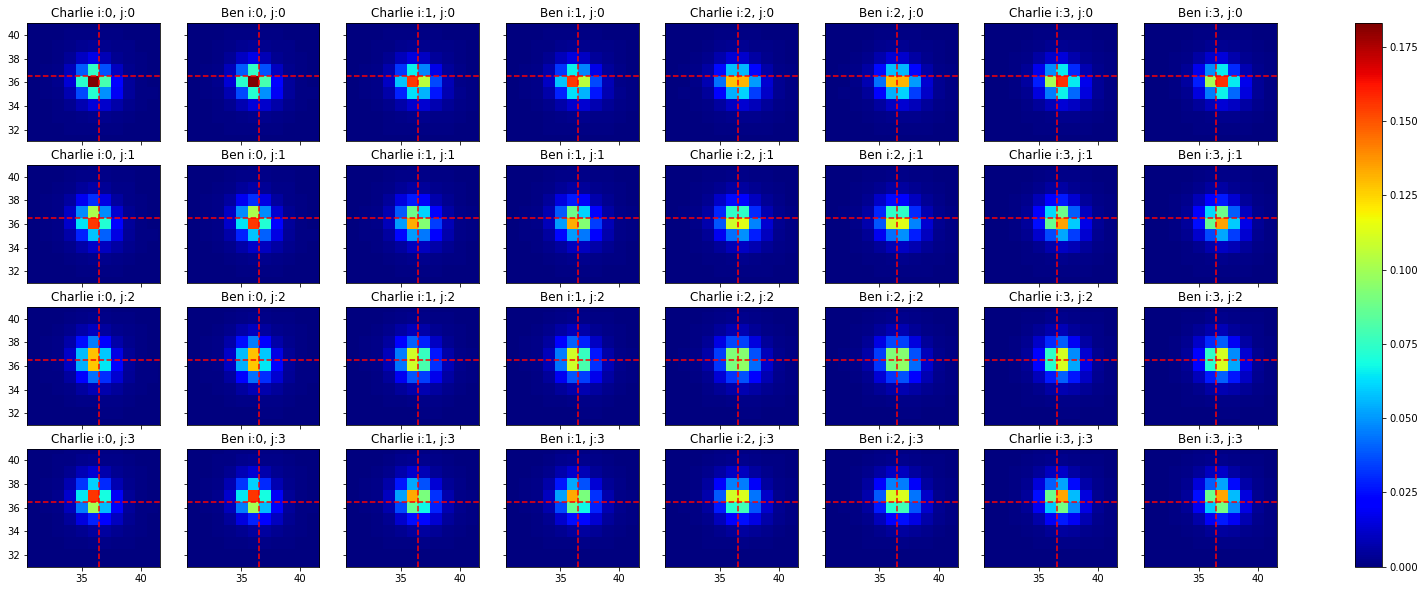

In [39]:
fig, axes = plt.subplots(ncols=8, nrows=4, figsize=(28, 10), sharex=True, sharey=True)
n1 = mpl.colors.Normalize()
n2 = mpl.colors.LogNorm()
for i in range(4):
    for j in range(4):
        plt.subplot(axes[j,2*i])
        plt.imshow(psf_c[j,i], norm=n1, cmap='jet')
        axes[j,2*i].axvline(x=73/2, color='r', ls='--')
        axes[j,2*i].axhline(y=73/2, color='r', ls='--')
        axes[j,2*i].set_title('Charlie i:{0:d}, j:{1:d}'.format(i,j))
        plt.subplot(axes[j,2*i+1])
        plt.imshow(psf_me[j,i], norm=n1, cmap='jet')
        axes[j,2*i+1].axvline(x=73/2, color='r', ls='--')
        axes[j,2*i+1].axhline(y=73/2, color='r', ls='--')
        axes[j,2*i+1].set_title('Ben i:{0:d}, j:{1:d}'.format(i,j))
axes[0,0].set_xlim([31, 41])
axes[0,0].set_ylim([31, 41])
plt.colorbar(ax=list(axes.flatten()))
# plt.suptitle('Charlies PSFs')
plt.savefig('figures/psf_sidebyside.pdf')

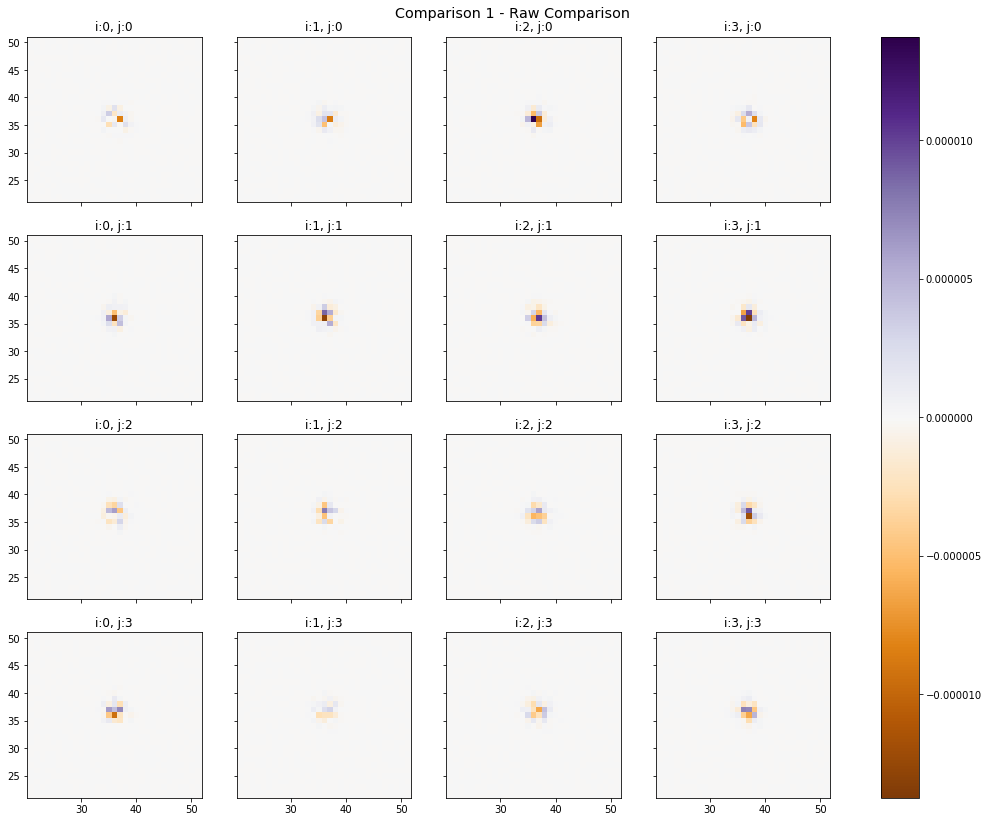

In [40]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(18, 14), sharex=True, sharey=True)
val = np.max(np.abs(psf_me - psf_c))
n1 = mpl.colors.Normalize(vmin=-val, vmax=val)
n2 = mpl.colors.LogNorm()
for i in range(4):
    for j in range(4):
        plt.subplot(axes[j,i])
        plt.imshow(psf_me[j,i] - psf_c[j,i], norm=n1, cmap='PuOr')
#         axes[j,i].axvline(x=73/2, color='r', ls='--')
#         axes[j,i].axhline(y=73/2, color='r', ls='--')
        axes[j,i].set_title('i:{0:d}, j:{1:d}'.format(i,j))
axes[0,0].set_xlim([21, 51])
axes[0,0].set_ylim([21, 51])
plt.colorbar(ax=list(axes.flatten()))
plt.suptitle('Comparison 1 - Raw Comparison', fontsize='x-large', y=0.91)
plt.savefig('figures/psf_compare_1.pdf')

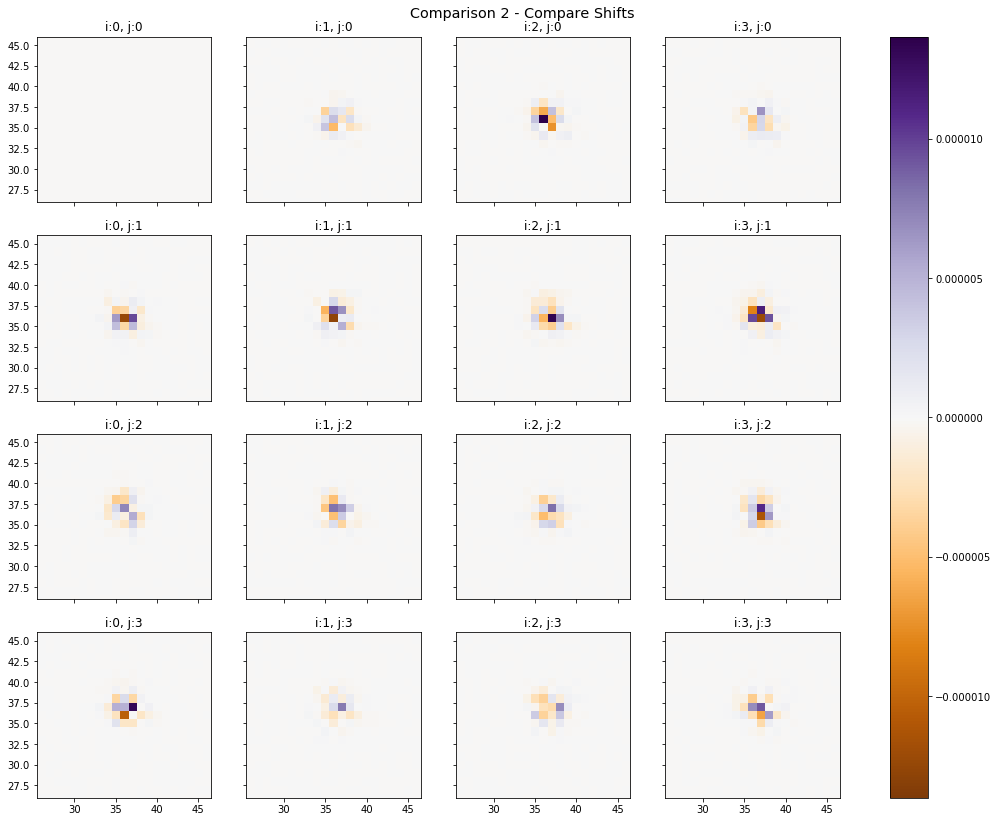

In [41]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(18, 14), sharex=True, sharey=True)
val = np.max(np.abs(psf_my_c - psf_c))
n1 = mpl.colors.Normalize(vmin=-val, vmax=val)
n2 = mpl.colors.LogNorm()
for i in range(4):
    for j in range(4):
        plt.subplot(axes[j,i])
        plt.imshow(psf_my_c[j,i] - psf_c[j,i], norm=n1, cmap='PuOr')
#         axes[j,i].axvline(x=73/2, color='r', ls='--')
#         axes[j,i].axhline(y=73/2, color='r', ls='--')
        axes[j,i].set_title('i:{0:d}, j:{1:d}'.format(i,j))
axes[0,0].set_xlim([26, 46])
axes[0,0].set_ylim([26, 46])
plt.colorbar(ax=list(axes.flatten()))
plt.suptitle('Comparison 2 - Compare Shifts', fontsize='x-large', y=0.91)
plt.savefig('figures/psf_compare_2.pdf')